In [1]:
import tensorflow as tf

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras

In [3]:
tf.executing_eagerly()

True

In [4]:
def plot_series(series, y=None, y_pred=None, title = None, x_label="$t$", y_label="$x(t)$"):
    n_steps = series.shape[0]
    plt.plot(series, ".-", label = 'Past Events')
    if y is not None:
        plt.plot(n_steps, y, "rx", markersize=8, label = 'Actual Future')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "go", label = 'Predicted Future')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    if title:
        plt.title(title)
    plt.legend()

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path);

In [6]:
dataframe = pd.read_csv(csv_path)
print('The dataset has {} observations'.format(dataframe.shape[0]))
features = list(dataframe.columns)
features = ('\n'.join(features))
print('The dataset has the following features: \n{}'.format(features))

The dataset has 420551 observations
The dataset has the following features: 
Date Time
p (mbar)
T (degC)
Tpot (K)
Tdew (degC)
rh (%)
VPmax (mbar)
VPact (mbar)
VPdef (mbar)
sh (g/kg)
H2OC (mmol/mol)
rho (g/m**3)
wv (m/s)
max. wv (m/s)
wd (deg)


Every observation is recorded every 10 minutes, so one hour has 6 observations, and a whole day has 144 observations. 
As we saw above, there are 420551 observations, and therefore, we have observations for around 8 years

In [7]:
print('The dataset goes from {} to {}'.format(dataframe['Date Time'].iloc[0][0:10], dataframe['Date Time'].iloc[-1][0:10]))

The dataset goes from 01.01.2009 to 01.01.2017


Taking all the observations would be very memory consuming. Thus, we can use a time window of 2 years (105000 observations, let's round it up to 110000) to predict the weather in 6 hours (36 observations ahead).

Let's create a function that allows us to take as many observations as we want. We will use this function later, when we need to split the data into training, validation, and testing

In [8]:
def window(data, start_index, end_index, history_size, target_size):
    data_list = []
    labels_list = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(data) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data_list.append(np.reshape(data[indices], (history_size, 1)))
        labels_list.append(data[i+target_size])
        
    return np.array(data_list), np.array(labels_list)

In [9]:
temp_pred = dataframe['T (degC)'][-20:]
temp = dataframe['T (degC)']
temp.index = dataframe['Date Time'] # Change the numerical index for its corresponding date

We can see that the values goes from -20C to around 35C. It is not a huge change of scale, but it would be a good idea to normalize the data to train our model.
Recall that we just normalize the training data, so it takes the mean and standard deviation of the training set rather than the whole dataset

In [10]:
temp_arr = temp.values # transform from series to numpy
temp_pred_arr = temp_pred.values

In [12]:
n_train = 110000
temp_mean = temp_arr[:n_train].mean()
temp_std = temp_arr[:n_train].std()
temp_norm = (temp_arr-temp_mean)/temp_std

In [13]:
n_batch = 20 # Number of observations in each batch
n_future = 2 # How many steps ahead from the training data

x_train_temp, y_train_temp = window(temp_norm, 0, n_train, n_batch, n_future)
x_val_temp, y_val_temp     = window(temp_norm, n_train, None, n_batch, n_future)

![title](Time_series.png)

Before getting our hands dirty, it would be nice to have some baseline metrics, so after training the model, we have something to compare our model with.

There are many ways to do this comparison, such as the mean, or the naive forecasting (which assumes that the following data is the same as the last value)

![title](Metrics.png)

In [14]:
batch_train = 256
n_buffer = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train_temp, y_train_temp))
train_data = train_data.cache().shuffle(n_buffer).batch(batch_train).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val_temp, y_val_temp))
val_data = val_data.batch(batch_train).repeat()

## Mean Forecasting

Let's take the first time window, and compute its mean. 
The predicted value will be the result

In [15]:
val_data.take(3)

<TakeDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

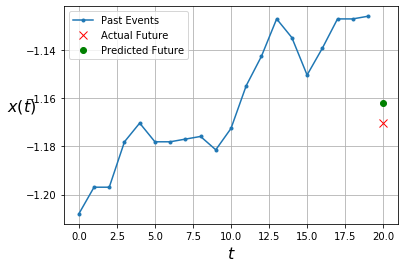

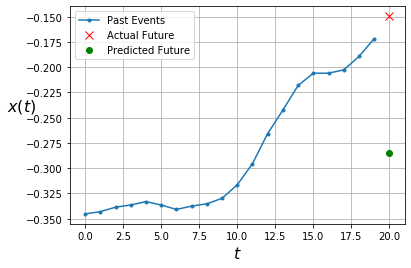

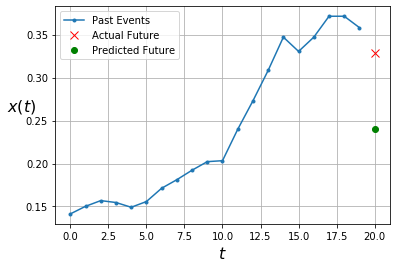

In [16]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=tf.math.reduce_mean(x[0]))
    plt.show()

The metric we can use is the MSE

## Naive Forecasting

Let's take the fifth window for sake of clarity.
The predicted value will be the same as the last value in the training set

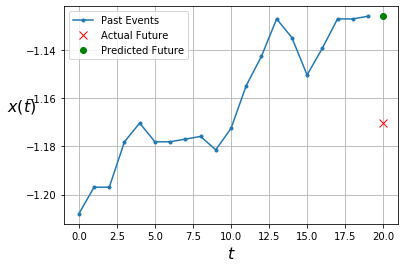

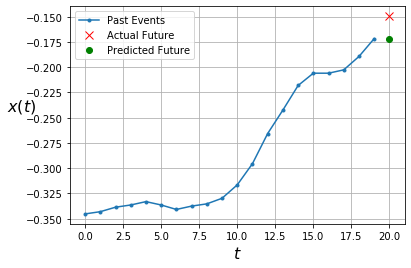

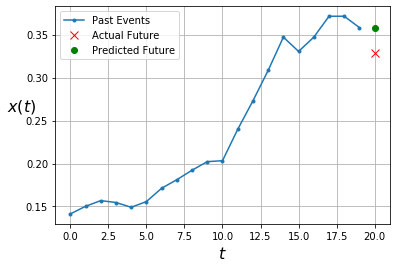

In [17]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=x[0,-1])
    plt.show()

We have our first baselines. Another easy baseline is using a linear neural network

## Linear Forecasting

In [18]:
np.random.seed(42) 
tf.random.set_seed(42)
keras.backend.clear_session

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=x_train_temp.shape[-2:]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")
model.fit(train_data, epochs=20,  steps_per_epoch=200,
            validation_data=val_data, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 2s 11ms/step - loss: 0.5993 - val_loss: 0.0664
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0451 - val_loss: 0.0607
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0415 - val_loss: 0.0530
Epoch 4/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0353 - val_loss: 0.0454
Epoch 5/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0297 - val_loss: 0.0381
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0254 - val_loss: 0.0313
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0197 - val_loss: 0.0259
Epoch 8/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0178 - val_loss: 0.0209
Epoch 9/20
200/200 [==============================] - 1s 6ms/step - loss: 0.0137 - val_loss: 0.0171
Epoch 10/20
200/200 [==============================] 

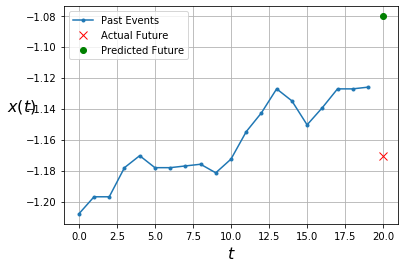

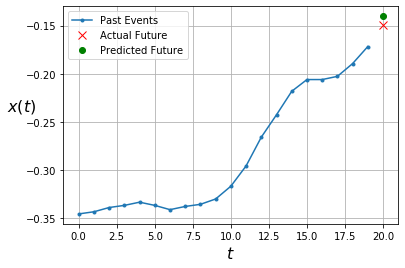

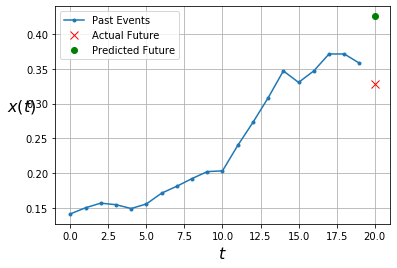

In [19]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=model.predict(x)[0])
    plt.show()

# Simple RNN

In [20]:
np.random.seed(42) # Pon estos valores en los random, así tenemos los mismos resultados
tf.random.set_seed(42)
keras.backend.clear_session

model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(1, input_shape = x_train_temp.shape[-2:]))

model.compile(loss="mse", optimizer="adam")
model.fit(train_data, epochs=20,
            steps_per_epoch=200,
            validation_data=val_data, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 4s 19ms/step - loss: 0.1774 - val_loss: 0.0978
Epoch 2/20
200/200 [==============================] - 4s 19ms/step - loss: 0.1813 - val_loss: 0.0879
Epoch 3/20
200/200 [==============================] - 4s 21ms/step - loss: 0.1524 - val_loss: 0.0818
Epoch 4/20
200/200 [==============================] - 4s 21ms/step - loss: 0.1744 - val_loss: 0.0782
Epoch 5/20
200/200 [==============================] - 4s 22ms/step - loss: 0.1559 - val_loss: 0.0769
Epoch 6/20
200/200 [==============================] - 4s 19ms/step - loss: 0.1644 - val_loss: 0.0742
Epoch 7/20
200/200 [==============================] - 4s 20ms/step - loss: 0.1508 - val_loss: 0.0726
Epoch 8/20
200/200 [==============================] - 4s 20ms/step - loss: 0.1590 - val_loss: 0.0709
Epoch 9/20
200/200 [==============================] - 4s 18ms/step - loss: 0.1409 - val_loss: 0.0694
Epoch 10/20
200/200 [===========================

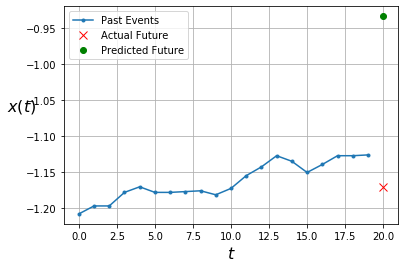

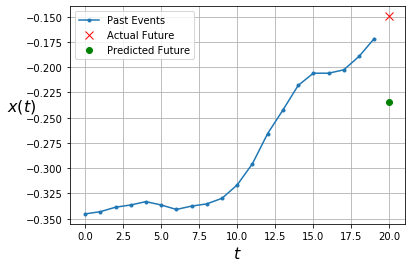

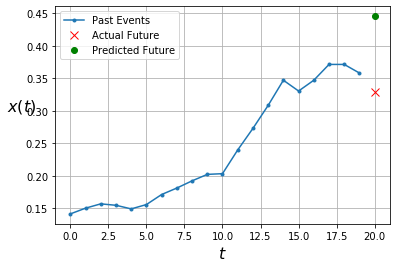

In [21]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=model.predict(x)[0])
    plt.show()

# Deep Recursive Neural Network

In [22]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:, -1])

np.random.seed(42) 
tf.random.set_seed(42)
keras.backend.clear_session
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = x_train_temp.shape[-2:]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.SimpleRNN(1)
    ])
model.compile(loss="mse", optimizer='adam', metrics=[last_time_step_mse])
model.fit(train_data, epochs=20,
            steps_per_epoch=200,
            validation_data=val_data, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 14s 71ms/step - loss: 0.1681 - last_time_step_mse: 0.1681 - val_loss: 0.0745 - val_last_time_step_mse: 0.0745
Epoch 2/20
200/200 [==============================] - 11s 57ms/step - loss: 0.1530 - last_time_step_mse: 0.1530 - val_loss: 0.0640 - val_last_time_step_mse: 0.0640
Epoch 3/20
200/200 [==============================] - 14s 70ms/step - loss: 0.1229 - last_time_step_mse: 0.1229 - val_loss: 0.0603 - val_last_time_step_mse: 0.0603- last_time_step_mse - ETA: 1s - loss: 0.1257 - 
Epoch 4/20
200/200 [==============================] - 15s 77ms/step - loss: 0.1483 - last_time_step_mse: 0.1483 - val_loss: 0.0583 - val_last_time_step_mse: 0.0583
Epoch 5/20
200/200 [==============================] - 11s 57ms/step - loss: 0.1343 - last_time_step_mse: 0.1343 - val_loss: 0.0572 - val_last_time_step_mse: 0.0572
Epoch 6/20
200/200 [==============================] - 12s 61ms/step - loss: 0.1424 - last

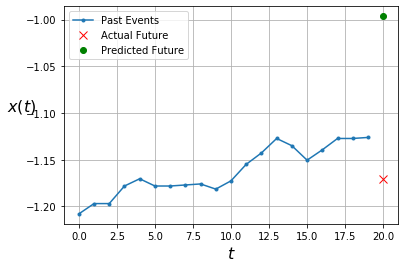

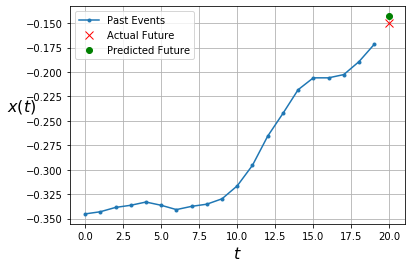

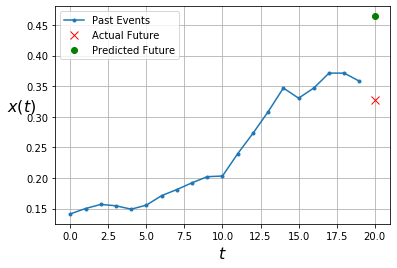

In [23]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=model.predict(x)[0])
    plt.show()

## Long Short-Term Memory Cells

In [24]:
np.random.seed(42) 
tf.random.set_seed(42)
keras.backend.clear_session

model = keras.models.Sequential([
    keras.layers.LSTM(8, input_shape=x_train_temp.shape[-2:]),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[last_time_step_mse])
model.fit(train_data, epochs=20,  steps_per_epoch=200,
            validation_data=val_data, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 9s 45ms/step - loss: 0.2443 - last_time_step_mse: 0.2443 - val_loss: 0.0672 - val_last_time_step_mse: 0.0672
Epoch 2/20
200/200 [==============================] - 7s 34ms/step - loss: 0.0407 - last_time_step_mse: 0.0407 - val_loss: 0.0204 - val_last_time_step_mse: 0.0204
Epoch 3/20
200/200 [==============================] - 7s 34ms/step - loss: 0.0187 - last_time_step_mse: 0.0187 - val_loss: 0.0119 - val_last_time_step_mse: 0.0119
Epoch 4/20
200/200 [==============================] - 7s 36ms/step - loss: 0.0122 - last_time_step_mse: 0.0122 - val_loss: 0.0083 - val_last_time_step_mse: 0.0083
Epoch 5/20
200/200 [==============================] - 7s 36ms/step - loss: 0.0091 - last_time_step_mse: 0.0091 - val_loss: 0.0077 - val_last_time_step_mse: 0.0077
Epoch 6/20
200/200 [==============================] - 7s 37ms/step - loss: 0.0075 - last_time_step_mse: 0.0075 - val_loss: 0.0059 - val_last_t

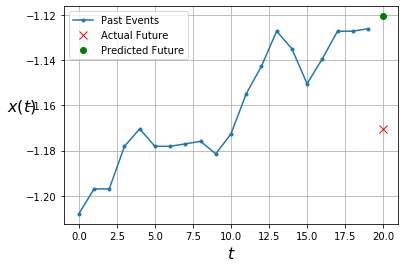

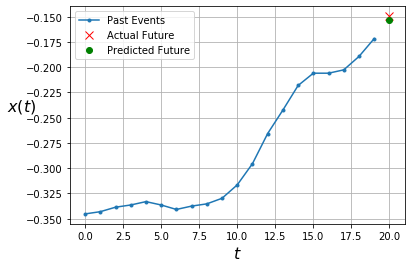

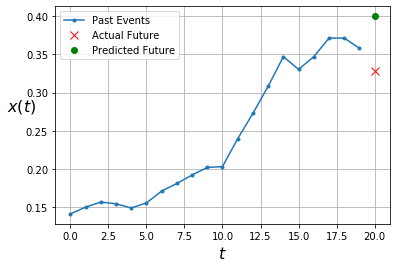

In [26]:
for x, y in val_data.take(3):
    plot_series(series = x[0], y=y[0].numpy(), y_pred=model.predict(x)[0])
    plt.show()

# Several Steps ahead

We can also set how many steps ahead we want to predict. First, let's make a new version of the window function we declared above. The difference in this case is that we provide both dataset and target.

We are also going to modify to have a boolean variable to specify is we want just one single step, or a sequence of steps

In [ ]:
def windows_ahead(series, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data_list = []
    labels_list = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(series) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data_list.append(series[indices])

    if single_step:
        labels_list.append(target[i+target_size])
    else:
        labels_list.append(target[i:i+target_size])

    return np.array(data_list), np.array(labels_list)

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = dataframe[features_considered]
features.index = dataframe['Date Time']

dataset = features.values
data_mean = dataset[:n_train].mean(axis=0)
data_std = dataset[:n_train].std(axis=0)
features.head()
dataset = (dataset-data_mean)/data_std

In [ ]:
past_history = 720
future_target = 72
step = 6
x_train_multi, y_train_multi = windows_ahead(series = dataset, target = dataset, start_index = 0,
                                                 end_index = n_train, history_size = past_history,
                                                 target_size = future_target, step = step)
x_val_multi, y_val_multi = windows_ahead(dataset, dataset[:, 1],
                                             n_train, None, past_history,
                                             future_target, step)

In [ ]:
batch_train = 256
n_buffer = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(n_buffer).batch(batch_train).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi,y_val_multi))
val_data_multi = val_data_multi.batch(batch_train).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_temp))